In [4]:
import sys
import os
from pathlib import Path

p = Path(os.path.abspath(os.getcwd()))
path = Path(p)
sys.path.insert(0, str(path.parent.absolute()) + '/sub')

from imu_processing import *
from plotting import *
import pandas as pd
import numpy as np
from machine_learning import *
from infer_mag import *
import scipy.signal as signal
from scipy.spatial.transform import Rotation as R
import copy

cwd = str(path.parent.parent.absolute())
data_cwd = cwd + '/Data/'
labels = os.listdir(data_cwd + '/Sample')

model_path = cwd+"/Models/"
svm = load_model(model_path + "SVM20230312")

In [9]:
class MagInfer():
    def __init__(self, gyro, mag, ws):
        self.gyro = gyro
        self.mag = mag
        self.ws = ws
    
    def _get_orientation(self, start, end):
        res = []
        for i in range(3):
            g = np.array(self.gyro[i][start:end]).sum() * 0.01
            res.append(g)
        
        return self.convert_to_rotation(res)
    
    def convert_to_rotation(self, orientation):
        r = R.from_euler('xyz', orientation, degrees = False)
        
        return r.as_matrix()
        
    def get_infered_mag(self, t):
        interval = int(self.ws * 100)
        
        reference_mag = [self.mag[i][t-interval] for i in range(3)]
        
        orientation = self._get_orientation(t-interval, t)
        infered_mag = np.matmul(np.linalg.inv(orientation), reference_mag)
        
        return infered_mag

In [10]:
class State:
    def __init__(self):
        self.DETECT = 2
        self.TILTED_DETECT = 1
        self.NON_DETECT = 0
        self.tilted_time = 0
        self.magnitude_time = 0
        self.state = self.NON_DETECT
        
    def detached(self):
        self.state = self.NON_DETECT
    
    def tilted_detect(self, t):
        self.tilted_time = t
        self.state = self.TILTED_DETECT
    
    def magnitude_detect(self, t):
        self.state = self.DETECT
        self.magnitude_time = t
    
    def update(self, t):
        if t-self.tilted_time >= 100 and self.state ==self.TILTED_DETECT:
            self.state = self.NON_DETECT
    
class Detection():
    def __init__(self, data, model, ws= 0.01):
        self.acc = self._data_to_lst(data, 'acc')
        self.gyro = self._data_to_lst(data, 'gyro')
        self.mag = self._data_to_lst(data, 'mag')
        self.l = len(self.mag[0])
        self.ws = ws
        self.mag_infer = MagInfer(self.gyro, self.mag, self.ws)
        self.state = State()
        self.model = model
    
    def _data_to_lst(self, data, name):
        res = []
        lst = ['X', 'Y', 'Z']
        
        for i in lst:
            res.append(data[name + i])
        return res
    
    def _tilted_value(self, original, infered):
        dot_product = np.dot(original, infered)
        magnitude = np.linalg.norm(original) * np.linalg.norm(infered)
        cos_angle = dot_product/magnitude

        
        return np.degrees(np.arccos(cos_angle))
    
    def _get_magnetometer_magnitude(self, t):
        res = np.array([self.mag[i][t]*self.mag[i][t] for i in range(3)]).sum()
        
        return math.sqrt(res)
    
    def infer_mag(self):
        def make_single_data(data):
            '''
            input : [magx data, magy data, magz data]
            '''
            keys = ['magX', 'magY', 'magZ']
            datas = {key : [] for key in keys}

            for idx, key in enumerate(keys):
                datas[key].append(data[idx])

            return pd.DataFrame(datas)
    
        b, a = signal.butter(5, 10/(100/2), btype='highpass')
        magnitude_time = self.state.magnitude_time
        tilted_time = self.state.tilted_time
        
        after_detect_magnitudes = self.magnitudes[magnitude_time-20:magnitude_time+10]
        filtered_magnitude = signal.filtfilt(b, a,after_detect_magnitudes)

        init_time = self.tilted_angles.index(min(self.tilted_angles[tilted_time-20:tilted_time]))
        finish_time = magnitude_time + filtered_magnitude.tolist().index(min(filtered_magnitude[10:]))
        
        reference_mag = [self.mag[i][init_time] for i in range(3)]
        print('init time {}   finish time {}'.format(init_time, finish_time))
        
        single_data = [self.mag[i][finish_time] - reference_mag[i] for i in range(3)]
        data = make_single_data(single_data)
        print(data)
        print(self.model.predict(data))
        
        return [init_time, finish_time]
        
    
    def solve(self, th = 20, cutoff = 10):
        b, a = signal.butter(5, cutoff/(100/2), btype='highpass')
        interval = int(self.ws * 100)
        
        self.tilted_angles = []
        self.magnitudes = []
        self.diff_ref_real = []
        self.times = []
        
        print(self.l)
        
        for t in range(interval, self.l):
            real_mag = np.array([self.mag[i][t] for i in range(3)])
            reference_mag = np.array([self.mag[i][t-interval] for i in range(3)])
            infered_mag = self.mag_infer.get_infered_mag(t)
            magnitude_mag = self._get_magnetometer_magnitude(t)
            
            self.magnitudes.append(magnitude_mag)
            tilted_angle = self._tilted_value(infered_mag, real_mag)
            diff_mag = self._tilted_value(reference_mag, real_mag)
            self.tilted_angles.append(tilted_angle)
            self.diff_ref_real.append(diff_mag)
            
            if self.state.state == self.state.NON_DETECT and tilted_angle >= 5 and abs(tilted_angle-diff_mag) <= 1:
                print('Tilted time {} tilted_value {} diff_value {}'.format(t, tilted_angle, abs(tilted_angle-diff_mag)))
                self.state.tilted_detect(t-20 if t -20>=0 else 0)

            if self.state.state == self.state.TILTED_DETECT and t-self.state.tilted_time >= 0:
                detect_time = self.state.tilted_time
                filtered_data = signal.filtfilt(b, a, self.magnitudes[detect_time:t])
                peak = max([abs(max(filtered_data)), abs(min(filtered_data))])

                if peak >= 1.0:
                    print('{} detect, Magnitude peak {}'.format(t, peak))
                    self.state.magnitude_detect(t)
                    
            if self.state.state == self.state.DETECT and t >= self.state.magnitude_time + 10:
                self.times = self.infer_mag()
                self.state.detached()
                
        
            self.state.update(t)

C:\Users\jaemi\lab_magacc/Data/Test_nature2/bandgripBlack/Imu 2023-03-30 16-03-30
819
Tilted time 508 tilted_value 6.540985395069076 diff_value 0.022075010898709557
509 detect, Magnitude peak 1.319465200768383
init time 469   finish time 531
        magX       magY      magZ
0 -26.945644  53.031262 -8.968269
['bandgripBlack']


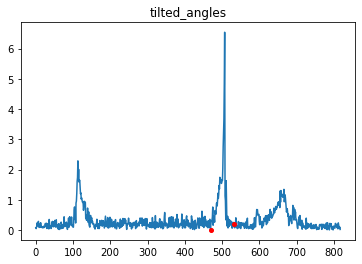

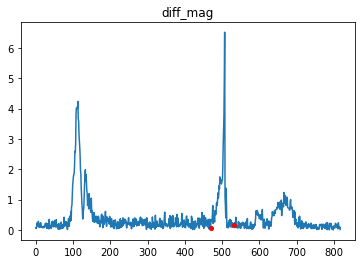

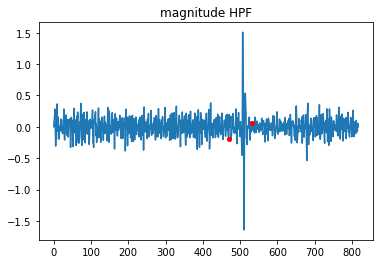

In [ ]:
class Values():
    def __init__(self):
        self.angles = []
        self.magnitudes = []
        
    def append_values(self, angle, magnitude):
        self.angles.append(angle)
        self.magnitudes.append(magnitude)

def plot_graph(graph, title = "title", emp = []):
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(graph)
    for points in emp:
        ax.plot(points, graph[points], marker = 'o', markersize = 4, color = 'red')
   
    plt.show()

path = data_cwd + 'test0331/'
#path = data_cwd + 'Test_outside/outside'
path = data_cwd + 'Test_nature2'
#path = data_cwd + 'Test_inside'
b, a = signal.butter(5, 10/(100/2), btype='highpass')
label_values = {label : Values() for label in labels}
imu_data = IMU(path)

start, end = 0, 2

for t in range(start, end):
    f = imu_data[t]
    print(f.path)
    data = f.data

    detect = Detection(data, svm, ws= 0.01)
    detect.solve()
    
    tilted_angles = detect.tilted_angles
    diff_mag = detect.diff_ref_real
    times = detect.times
    magnitudes = detect.magnitudes
    
    plot_graph(tilted_angles, title = 'tilted_angles', emp = times)
    plot_graph(diff_mag, title = 'diff_mag', emp = times)
    filtered_data = signal.filtfilt(b, a, magnitudes)
    plot_graph(filtered_data, title = "magnitude HPF", emp = times)
    
    lst = [abs(diff_mag[t]-tilted_angles[t]) for t in range(len(diff_mag))]
    plot_graph(lst, title = "Sub of diff_mag and tilted_angle", emp =times)
    
#     angle_max = abs(max(tilted_angle)) if abs(max(tilted_angle)) > abs(min(tilted_angle)) else abs(min(tilted_angle))
#     mag_max = abs(max(filtered_data)) if abs(max(filtered_data)) > abs(min(filtered_data)) else abs(min(filtered_data))
#     label_values[f.label].append_values(angle_max, mag_max)
    
    for g in detect.mag:
        plot_graph(g, title = 'magnetomter', emp = times)

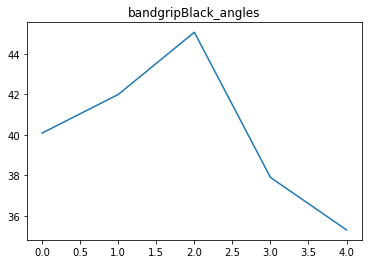

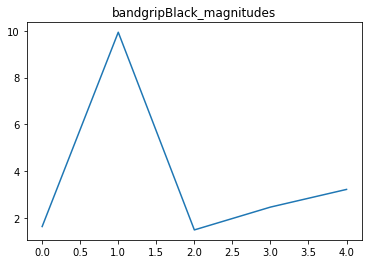

---------------------------------------------------


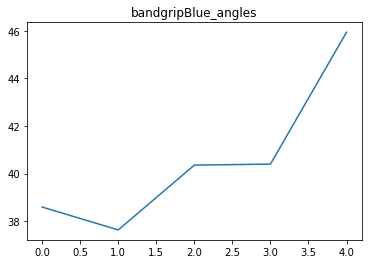

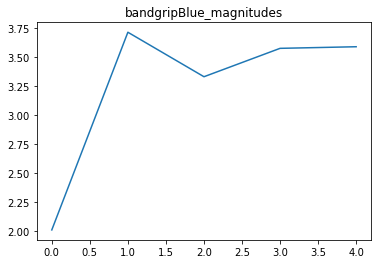

---------------------------------------------------


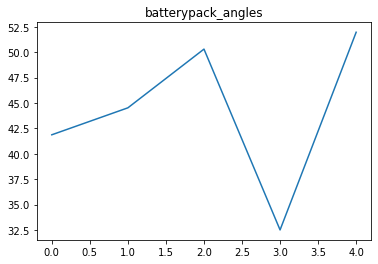

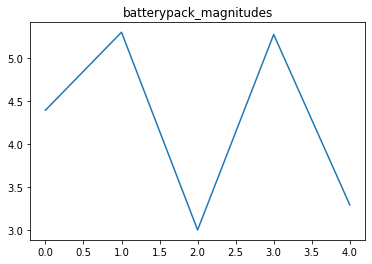

---------------------------------------------------


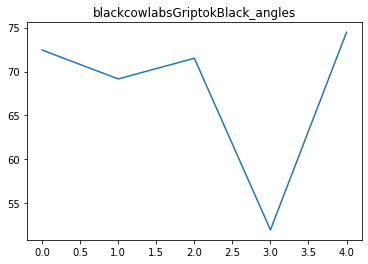

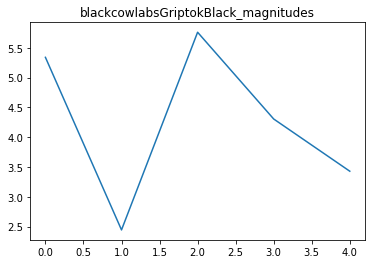

---------------------------------------------------


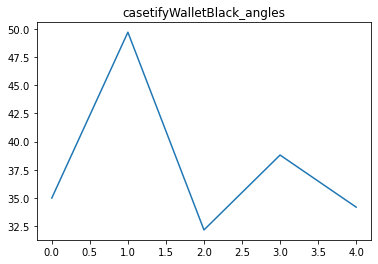

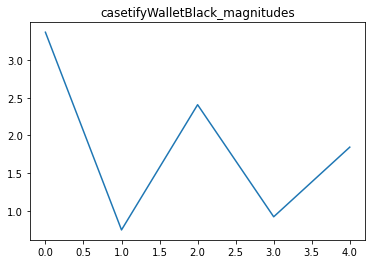

---------------------------------------------------


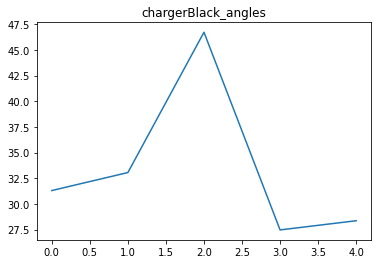

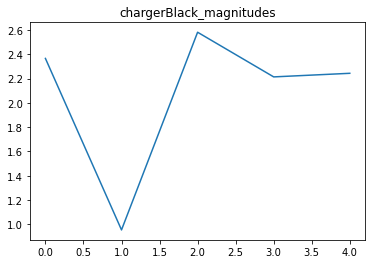

---------------------------------------------------


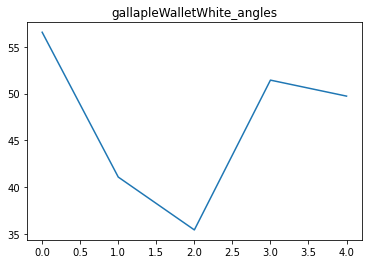

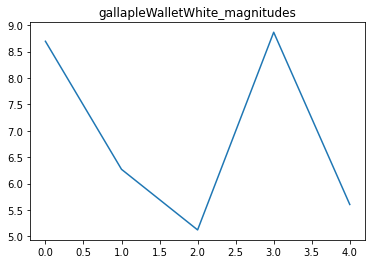

---------------------------------------------------


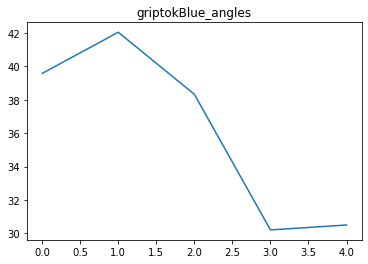

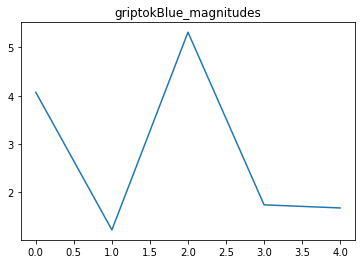

---------------------------------------------------


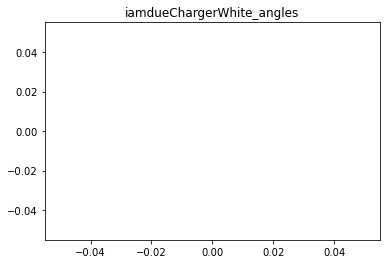

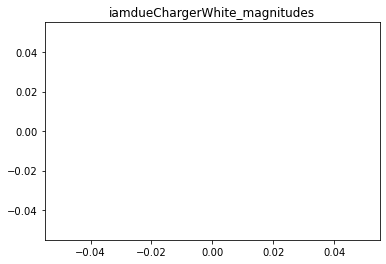

---------------------------------------------------


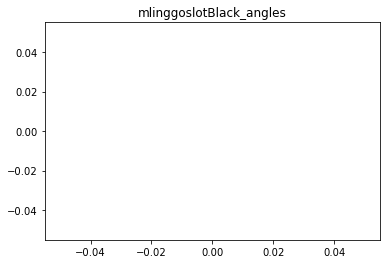

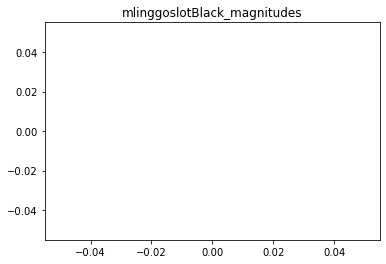

---------------------------------------------------


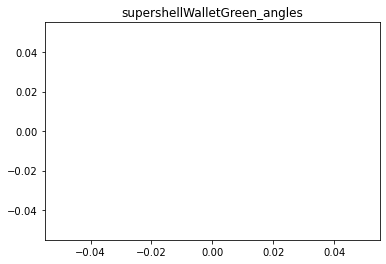

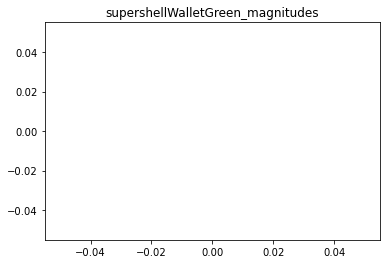

---------------------------------------------------


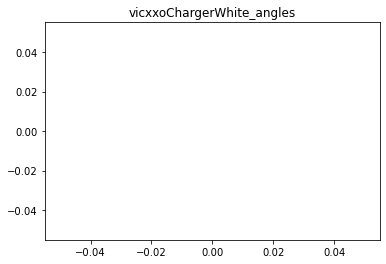

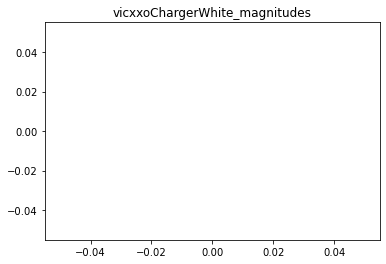

---------------------------------------------------


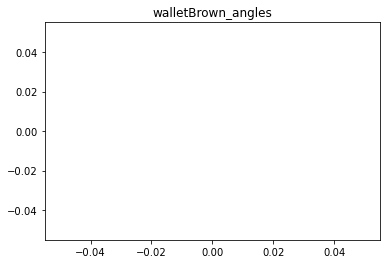

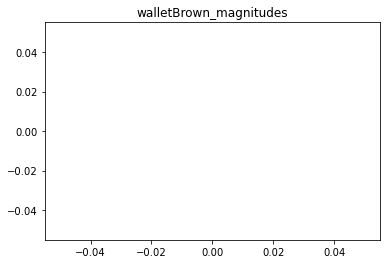

---------------------------------------------------


In [51]:
for key, value in label_values.items():
    plot_graph(value.angles, title = key + '_angles')
    plot_graph(value.magnitudes, title = key + '_magnitudes')
    print('---------------------------------------------------')